## Exploration of CommonCrawl dumps

URL to download the file I used:

https://commoncrawl.s3.amazonaws.com/crawl-data/CC-MAIN-2018-09/segments/1518891807660.32/wet/CC-MAIN-20180217185905-20180217205905-00004.warc.wet.gz

In [1]:
import re
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
fname = '/mnt/hdd/Data/CommonCrawl/CC-MAIN-20180217185905-20180217205905-00004.warc.wet'
wet = open(fname, 'r').read()

In [3]:
parts = re.findall(r'(WARC/1.0.*?)WARC/1.0', wet, re.S)

This WET-file from CommonCrawl contains scraped content from thousands of web-pages in different languages. At the head of the file is metadata for the whole file:

In [4]:
print(parts[0].strip())

WARC/1.0
WARC-Type: warcinfo
WARC-Date: 2018-02-18T16:46:36Z
WARC-Filename: CC-MAIN-20180217185905-20180217205905-00004.warc.wet.gz
WARC-Record-ID: <urn:uuid:7e9adda2-bbe1-4d92-96ce-2f469a6263d5>
Content-Type: application/warc-fields
Content-Length: 263

Software-Info: ia-web-commons.1.1.9-SNAPSHOT-20180106080755
Extracted-Date: Sun, 18 Feb 2018 16:46:36 GMT
robots: classic
isPartOf: CC-MAIN-2018-09
operator: Common Crawl Admin
description: Wide crawl of the web for February 2018
publisher: Common Crawl


Next are web-page contents, each preceded by metadata of its own:

In [5]:
print(parts[1].strip()[:600])

WARC/1.0
WARC-Type: conversion
WARC-Target-URI: http://0000hotdreams.sexeclips.com/live-cam-chat/SophiaCollins
WARC-Date: 2018-02-17T19:43:57Z
WARC-Record-ID: <urn:uuid:7d9da6d5-a871-4368-adc9-9b54a06288c6>
WARC-Refers-To: <urn:uuid:10684606-ca57-4801-9d61-e20f851d8ada>
WARC-Block-Digest: sha1:26ETBV5D5QSIF7LNK5ZSSLJD5LZH2MBD
Content-Type: text/plain
Content-Length: 1963

﻿ SophiaCollins live cam chat naked
Sexeclips
Home
Services
About
Contact
☰
SophiaCollins
Free Chat Cam
SophiaCollins live cam chat room
SophiaCollins personal details: Here You are! My romantic, lonely boy - I must tell, You


Overall there are more than twenty thousand pages in a file:

In [6]:
print(len(parts))

21034


From page metadata most interesting information is URI and content-length.

In [7]:
uri_pat = r'WARC-Target-URI: (http://.*)\n'
uris = []
for p in parts[1:]:
    uri = re.search(uri_pat, p)
    if not uri:
        continue
    uris.append(uri.group(1).strip())
    
print('We got {l} URIs for web-pages'.format(l=len(uris)))

We got 15281 URIs for web-pages


In [8]:
cont_len_pat = r'Content-Length: ([0-9]+)'
cont_lens = []
for p in parts[1:]:
    cl = re.search(cont_len_pat, p)
    if not cl:
        continue
    cont_lens.append(int(cl.group(1).strip()))
    
print('We got {cl} values of content-length for web-pages'.format(cl=len(cont_lens)))

We got 21033 values of content-length for web-pages


Finally, we extract separately textual content of each page for further analysis.

In [9]:
cont_pat = r'Content-Length: [0-9]+\n(.*)'
pages = []
for p in parts[1:]:
    page = re.search(cont_pat, p, re.S)
    if not page:
        continue
    pages.append(page.group(1).strip())
    
print('We got {pl} web-page texts'.format(pl=len(pages)))

We got 21033 web-page texts


Start with analysis of URIs.

In [10]:
def get_domain(uri):
    return re.search(r'http://(.*?)(/|\?)', uri).group(1)

def get_tld(domain):
    return domain.split('.')[-1]

domains = [get_domain(uri) for uri in uris]
tlds = [get_tld(domain) for domain in domains]

In [11]:
dom_count = Counter(domains)
tld_count = Counter(tlds)

In [12]:
print('The most frequent domains are:')
print(dom_count.most_common(10))

The most frequent domains are:
[('www.planetsteelers.com', 27), ('iowagravestones.org', 18), ('www.drivethrurpg.com', 18), ('animeonly.org', 16), ('articles.courant.com', 15), ('mail-archives.apache.org', 15), ('puja.istationbd.com', 14), ('www.bostonglobe.com', 14), ('steamcommunity.com', 13), ('www.thewarpath.net', 13)]


In [13]:
print('The most common top-level domains are:')
print(tld_count.most_common(10))

The most common top-level domains are:
[('com', 7972), ('ru', 943), ('org', 861), ('net', 779), ('de', 442), ('jp', 312), ('uk', 303), ('info', 200), ('fr', 199), ('it', 192)]


In [14]:
avg_cl = np.mean(cont_lens)
med_cl = np.median(cont_lens)
print('Average content has length of {avg} and median of {md}'.format(avg=avg_cl, md=med_cl))
print('Content of the page has at least {mn} and at most {mx} symbols'
      .format(mn=min(cont_lens), mx=max(cont_lens)))

Average content has length of 7508.981315076308 and median of 4195.0
Content of the page has at least 2 and at most 596877 symbols


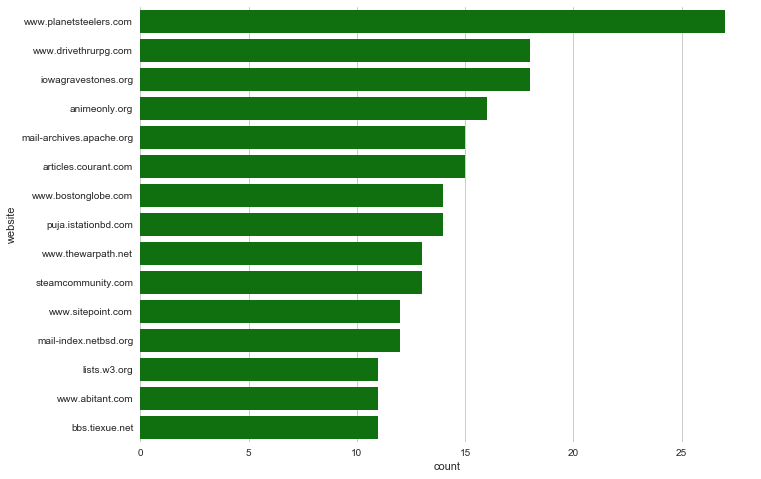

In [15]:
sns.set(rc={'figure.figsize':(11, 8)})
sns.set_style('whitegrid')
dom_df = pd.DataFrame.from_dict(dom_count, orient='index').reset_index()
dom_df = dom_df.rename(columns={'index': 'website', 0: 'count'})
sns.barplot(x='count', y='website', color='green',
            data=dom_df.sort_values(by='count', ascending=False)[:15])
sns.despine(bottom=True, left=True)

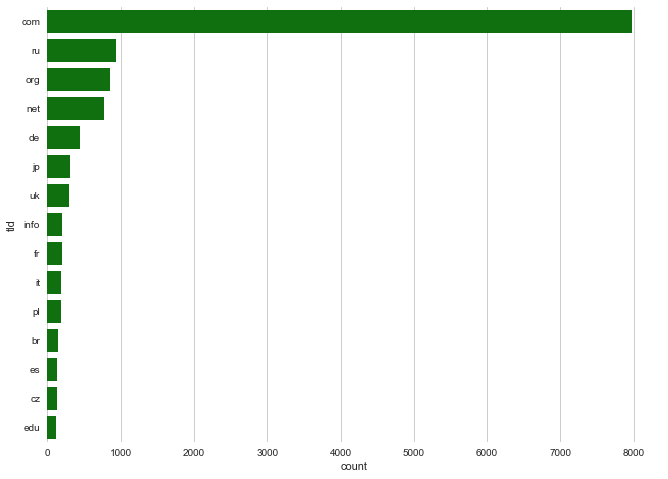

In [16]:
tld_df = pd.DataFrame.from_dict(tld_count, orient='index').reset_index()
tld_df = tld_df.rename(columns={'index': 'tld', 0: 'count'})
sns.barplot(x='count', y='tld', color='green',
            data=tld_df.sort_values(by='count', ascending=False)[:15])
sns.despine(bottom=True, left=True)

In [17]:
long_doms = sorted(domains, key=len)
print('The longest webpage name is {long}'.format(long=long_doms[-1]))
print('The shortest are {short}'.format(short=long_doms[:4]))

The longest webpage name is www.posicionamiento-paginas-web-sitios-web-buscadores.paginadigital.com.ar
The shortest are ['1a.by', 'io.no', 'w6.ru', 'zp.pl']


In [18]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import ngrams, FreqDist

In [19]:
def tokenize_page(webpage):
    try:
        sents = sent_tokenize(webpage)
        sent_toks = [word_tokenize(sent) for sent in sents]
        sent_toks = [[w.strip() for w in toks] for toks in sent_toks]
        return sent_toks
    except:
        return None

Tokenization takes some time.

In [20]:
tokenized = [tokenize_page(page) for page in pages]

In [21]:
# flatten the lists of lists of tokens
tokens = [t for toks in tokenized for t in toks]
tokens = [t for toks in tokens for t in toks]

In [22]:
print('In all, we got {l} tokens'.format(l=len(tokens)))

In all, we got 24582073 tokens


What about word frequencies? First, we'd better get rid of punctuation and too short words.

In [23]:
tokens = [t for t in tokens if len(t) > 4]
fdist = Counter(tokens)

In [24]:
fdist.most_common(20)

[('February', 12357),
 ('function', 12331),
 ('about', 12125),
 ('Contact', 10966),
 ('November', 10596),
 ('Search', 10493),
 ('January', 10474),
 ('September', 10387),
 ('About', 10236),
 ('August', 10176),
 ('April', 10085),
 ('October', 10078),
 ('March', 9427),
 ('December', 9425),
 ('their', 9202),
 ('return', 8496),
 ('Facebook', 8390),
 ('which', 8090),
 ('other', 7806),
 ('Email', 7666)]

Word "February" is one of the most common tokens, probably because dump is dated from February. 

To find what languages are most common, we use library langdetect.

In [25]:
from langdetect import detect

langs = []
for p in pages:
    try:
        lang = detect(p)
        langs.append(lang)
    except:
        continue

print('We have {l} pages with detected languages'.format(l=len(langs)))

We have 21028 pages with detected languages


English is the most common language by far.

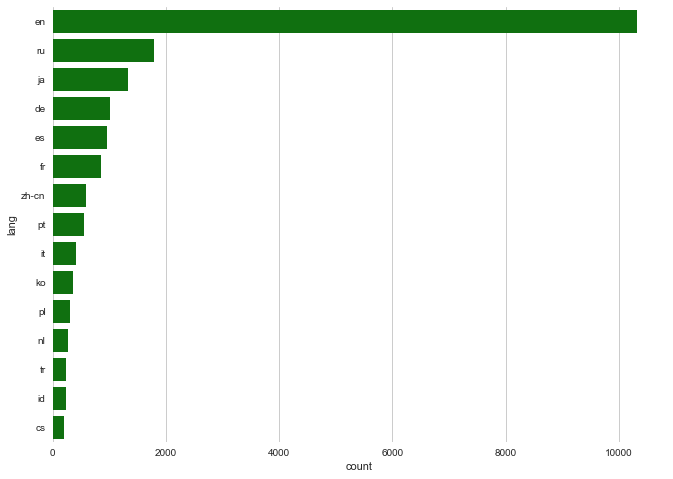

In [26]:
lang_count = Counter(langs)

lang_df = pd.DataFrame.from_dict(lang_count, orient='index').reset_index()
lang_df = lang_df.rename(columns={'index': 'lang', 0: 'count'})
sns.barplot(x='count', y='lang', color='green',
            data=lang_df.sort_values(by='count', ascending=False)[:15])
sns.despine(bottom=True, left=True)